In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import gdown

import matplotlib.pyplot as plt
import seaborn as sns

### Get Data

In [2]:
PATH_TO_DATA = "C:\\Users\\Peteris\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\"
# PATH_TO_DATA = "C:\\Users\\pich\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\"
file_name = "test-assignment-dataset.json"
data_url="https://drive.google.com/file/d/1Xx4ozrFDDmzDCuIyUTxjzj43eARpxW1o/view?usp=sharing"

In [3]:
def get_and_load_file(
        data_folder:str="../data/", filename=file_name,
        url:str=data_url)->pd.DataFrame:
    """
    Load JSON dataset into a DataFrame. 
    Download JSON dataset from a Google Drive URL, if not already present.
    :param data_folder: Path to the folder where the file should be stored or loaded from.
    :param filename: Name of the file to check, download, and load.
    :param url: Google Drive URL for downloading the file if it's not found locally.
    :return: A pandas DataFrame containing the data from the JSON file.
    """
    local_file_path = data_folder + filename
    if not Path(local_file_path).is_file():
        print(f"Source data file not present in {data_folder}, downloading file")
        gdown.download(url, local_file_path, fuzzy=True, quiet=False)  # quiet=True after testing
    df = pd.read_json(local_file_path)
    return df

df_source = get_and_load_file(data_folder=PATH_TO_DATA)  # change to default "../data/" after testing
df_source.sample(3)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,...,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
172698,42.0537,-9.78489,9.5,5.7,358,3.8,0,218.668,0.256787,853.090,...,3.62,302.37,9.53,15.63,35.82,-0.16,NaN,NaN,NaN,NaN
51536,58.5089,4.59774,11.8,5.9,358,355.4,0,255.870,0.303267,843.841,...,3.14,145.30,8.90,16.00,32.40,-0.12,NaN,NaN,NaN,NaN
113656,41.6458,31.87800,11.8,3.9,81,82.1,0,162.312,0.188311,862.241,...,0.00,33.08,2.43,19.05,18.54,0.01,NaN,NaN,NaN,NaN


### EDA

In [4]:
df_source.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'status', 'mainEngineMassFlowRate',
       'mainEngineVolumeFlowRate', 'mainEngineDensity',
       'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque', 'shaftPower',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentSpeed', 'gust', 'swellDirection',
       'swellHeight', 'swellPeriod', 'waveDirection', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveHeight', 'windWavePeriod',
       'windDirection', 'windSpeed', 'airTemperature', 'salinity', 'seaLevel',
       'recommendedMassFlowRate', 'expectedSpeedOverGround',
       'recommendedPower', 'expectedCarbonIntensityIndicator'],
      dtype='object')

In [5]:
print(df_source.shape)
df_source.info()

(326224, 43)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326224 entries, 0 to 326223
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   latitude                          326222 non-null  float64            
 1   longitude                         326222 non-null  float64            
 2   speedOverGround                   326224 non-null  float64            
 3   draught                           326220 non-null  float64            
 4   heading                           326224 non-null  int64              
 5   courseOverGround                  326222 non-null  float64            
 6   status                            326224 non-null  int64              
 7   mainEngineMassFlowRate            326224 non-null  float64            
 8   mainEngineVolumeFlowRate          326224 non-null  float64            
 9   mainEngineDensity                 3

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df_source.describe()

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,mainEngineTemperature,mainEngineFuelConsumed,auxEngineMassFlowRate,auxEngineVolumeFlowRate,auxEngineDensity,auxEngineTemperature,shaftSpeed,shaftTorque,shaftPower,specificFuelOilConsumption,fuelEfficiency,currentDirection,currentSpeed,gust,swellDirection,swellHeight,swellPeriod,waveDirection,waveHeight,wavePeriod,windWaveDirection,windWaveHeight,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
count,326222.000000,326222.000000,326224.000000,326220.000000,326224.000000,326222.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,3.262240e+05,3.262240e+05,170130.000000,308207.000000,308207.000000,326224.000000,317216.000000,317084.000000,317084.000000,308135.000000,319809.000000,305432.000000,316981.000000,316956.000000,317216.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,42376.000000,42376.000000,4.237600e+04,41735.000000
mean,49.632092,2.978693,4.950242,5.139615,193.701527,184.906974,2.346624,101.245179,0.117942,815.007951,24.161276,1.687420,6.928908,0.007913,831.910785,29.055252,91.172805,25018.630128,4.726122e+05,1.345341e+04,24.023266,175.602391,0.213010,9.238503,231.826153,0.832728,5.962773,200.727807,1.248696,4.953513,195.791109,0.622706,2.573644,191.147175,6.184837,13.429885,32.111769,0.139154,208.732514,10.394949,1.002439e+06,13.708862
std,7.842426,11.030812,5.310358,0.852991,94.737099,101.332097,2.450708,107.507566,0.125246,180.324604,6.350480,1.791793,5.631603,0.006469,89.815379,4.816925,90.952806,26582.660106,5.129609e+05,1.096295e+06,49.499521,97.980663,0.188869,5.095318,94.955289,1.083965,2.736090,89.367433,1.353802,2.578808,89.104112,0.856438,1.822063,90.703968,3.610953,7.193249,5.866357,0.890680,34.060448,1.817699,1.919168e+05,3.732638
min,35.889400,-23.062100,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,-102.695000,-36.085000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.480000,0.060000,0.010000,1.370000,0.130000,0.000000,1.270000,0.120000,0.000000,0.000000,0.000000,0.170000,-5.090000,8.500000,-3.650000,117.000000,2.714490,4.536688e+05,6.323664
25%,43.360600,-4.751288,0.000000,4.000000,119.000000,104.700000,0.000000,0.000000,0.000000,844.099000,19.763700,0.000000,0.000000,0.000000,833.019000,25.154087,0.230909,561.959000,1.137835e+01,0.000000e+00,16.982491,92.790000,0.090000,5.140000,168.610000,0.100000,3.970000,138.370000,0.390000,2.920000,133.280000,0.090000,1.450000,116.290000,3.350000,6.690000,30.380000,-0.280000,174.000000,9.030438,8.141896e+05,11.299184
50%,51.623500,3.744930,0.200000,5.600000,207.000000,191.400000,1.000000,0.223440,0.000000,859.116000,25.441300,0.003724,8.562600,0.009678,852.911500,29.616125,1.698130,1839.530000,2.460855e+02,1.509878e+02,19.791990,180.000000,0.150000,8.460000,263.920000,0.500000,5.690000,207.890000,0.810000,4.370000,203.150000,0.360000,2.230000,205.400000,5.330000,14.220000,34.920000,0.070000,200.000000,10.428973,9.676852e+05,12.926036
75%,54.436675,8.506670,10.600000,5.900000,271.000000,270.000000,5.000000,208.348250,0.242225,866.413000,27.714200,3.472471,10.602400,0.012155,863.605000,32.971000,182.396000,50966.000000,9.712270e+05,2.136662e+02,22.387983,259.750000,0.300000,12.870000,308.040000,1.060000,7.930000,276.440000,1.750000,5.990000,260.080000,0.790000,3.420000,255.000000,8.220000,19.260000,35.500000,0.550000,246.000000,11.423510,1.190503e+06,15.216035
max,66.328200,32.230000,17.300000,6.000000,359.000000,359.900000,5.000000,572.696000,0.680159,880.345000,149.950000,9.544933,28.019000,0.046928,875.904500,46.816250,185.733000,94223.400000,1.796530e+06,2.832681e+08,3176.

In [7]:
pd.reset_option('all')

C:\Users\Peteris\AppData\Local\Temp\ipykernel_236\2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\Peteris\AppData\Local\Temp\ipykernel_236\2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


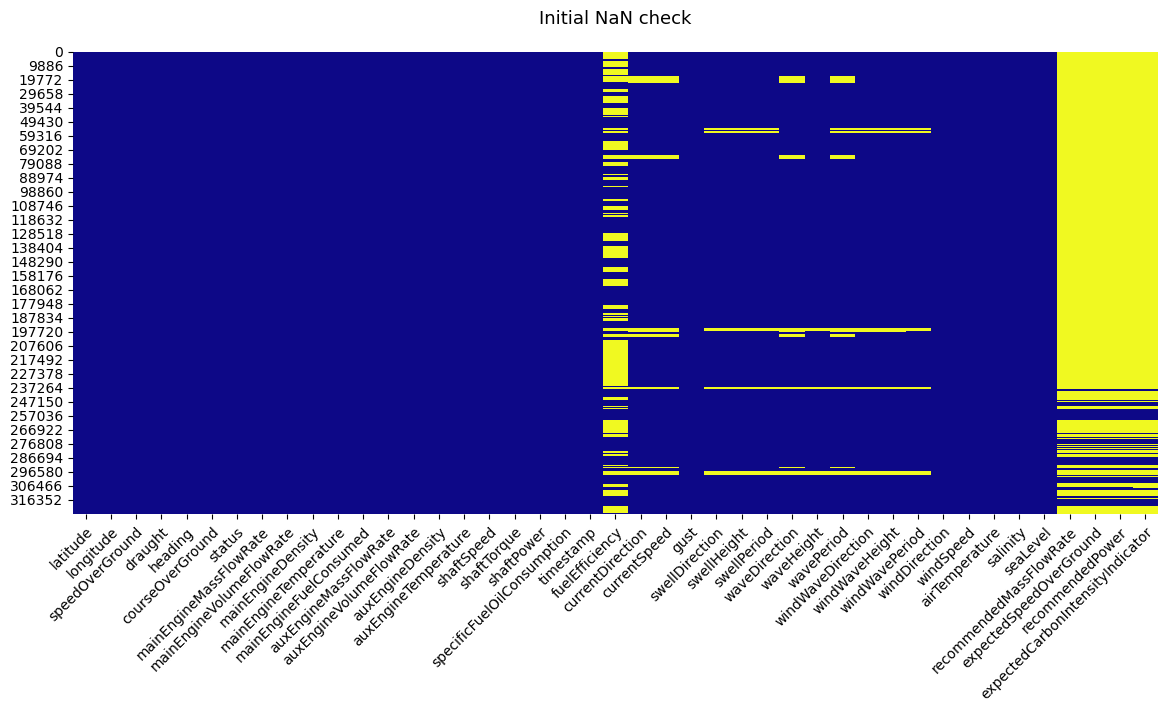

In [8]:
plt.figure(figsize=(df_source.shape[1] // 3, 6))
sns.heatmap(df_source.isnull(), cmap='plasma', cbar=False)
plt.title("Initial NaN check\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

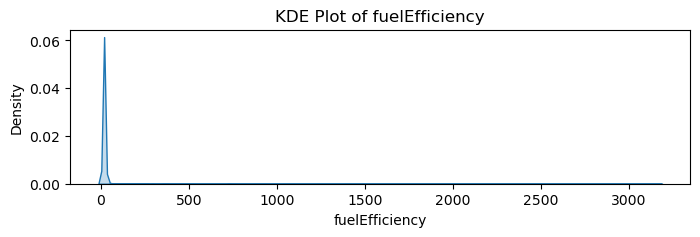

In [9]:
plt.figure(figsize=[8, 2])
sns.kdeplot(data=df_source['fuelEfficiency'].dropna(), fill=True)
plt.title('KDE Plot of fuelEfficiency')
plt.xlabel('fuelEfficiency')
plt.ylabel('Density')
plt.show()

In [10]:
df_source['fuelEfficiency'].value_counts(dropna=True, ascending=False, normalize=True).head(5)

fuelEfficiency
0.00     0.065826
20.55    0.000035
18.66    0.000029
19.74    0.000024
16.52    0.000024
Name: proportion, dtype: float64

In [11]:
nan_rows = df_source[df_source.loc[:, 'currentDirection':'seaLevel'].isnull().any(axis=1)].index  # rows, where specified columns contain NaNs
print(f"proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') \
against entire dataset:\n{round(len(nan_rows)/df_source.shape[0]*100, 1)}%")

proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') against entire dataset:
6.4%


- #### With only ~6% of rows containing missing values, I will delete them in training task:
    - To decide on best imputation strategy for missing environmental data (weather, sea conditions) domain expert is needed on:
        - whether mean/mode imputation is sufficient
        - Does dataset structure (eg row sequence, timestamp) has sufficient for k-neighbors imputation
        - does other columns are sufficient predictors to use regression imputation
- #### Drop 'recommendedMassFlowRate' and 'expectedCarbonIntensityIndicator' columns that are not target for current prediction task
- #### Replace 'fuelEfficiency' NaNs with zeroes as it is most popular value among "good" entries for the feature anyway

### Data Preprocessing

In [12]:
def clean_data(data:pd.DataFrame, nan_col_start='currentDirection',
               nan_col_end= 'seaLevel', cols_to_dorp = ['recommendedMassFlowRate', 
                                                        'expectedCarbonIntensityIndicator'],
               nan_to_zero_columns:list=["fuelEfficiency"],
               remove_nan_targets:bool=True)->pd.DataFrame:
    """
    Clean and preprocess the dataset for modeling:
    1) Create a deep copy of the input dataset to preserve the original data.
    2) Identify and drop rows with any NaN values between specified columns (inclusive).
    3) Remove predefined columns unrelated to model input.
    4) Fill missing values in the specified columns with 0.
    5) Optionally drop rows with missing values in the last two columns (assumed target variables).
    6) Drop columns that contain single unique value (not useful for ML algorithm)

    :param data: Input DataFrame to be cleaned.
    :param nan_col_start: Column name where NaN checking should begin (inclusive).
    :param nan_col_end: Column name where NaN checking should end (inclusive).
    :param remove_nan_targets: If True, removes rows with NaNs in the last two columns.
    :param nan_to_zero_columns: specify al list of columns where NaN values will be replaced by 0.
    :return: A cleaned DataFrame with rows and columns filtered and missing data handled.
    """
    df_new = data.copy(deep=True)
    if remove_nan_targets:
        df_new = df_new.dropna(subset=df_new.columns[-2:])  # drop rows without target variables

    nan_rows = df_new[df_new.loc[:, nan_col_start:nan_col_end].isnull().any(axis=1)].index
    df_new = df_new.drop(index=nan_rows)
    df_new = df_new.drop(columns=cols_to_dorp)
    if nan_to_zero_columns:
        for column in nan_to_zero_columns:
            df_new[column] = df_new[column].fillna(0)
    df_new = df_new.drop(columns=[col for col in df_new.columns 
                                  if df_new[col].nunique(dropna=False) == 1])

    return df_new

df_clean = clean_data(df_source)
df_clean.shape

(41451, 40)

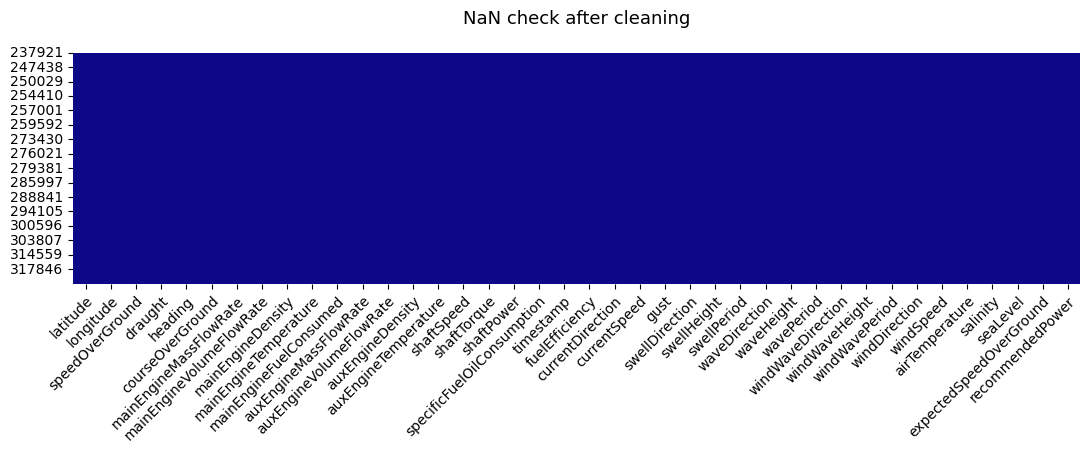

In [13]:
plt.figure(figsize=(df_clean.shape[1] // 3, 3))
sns.heatmap(df_clean.isnull(), cmap='plasma', cbar=False)
plt.title("NaN check after cleaning\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Feature Selection 

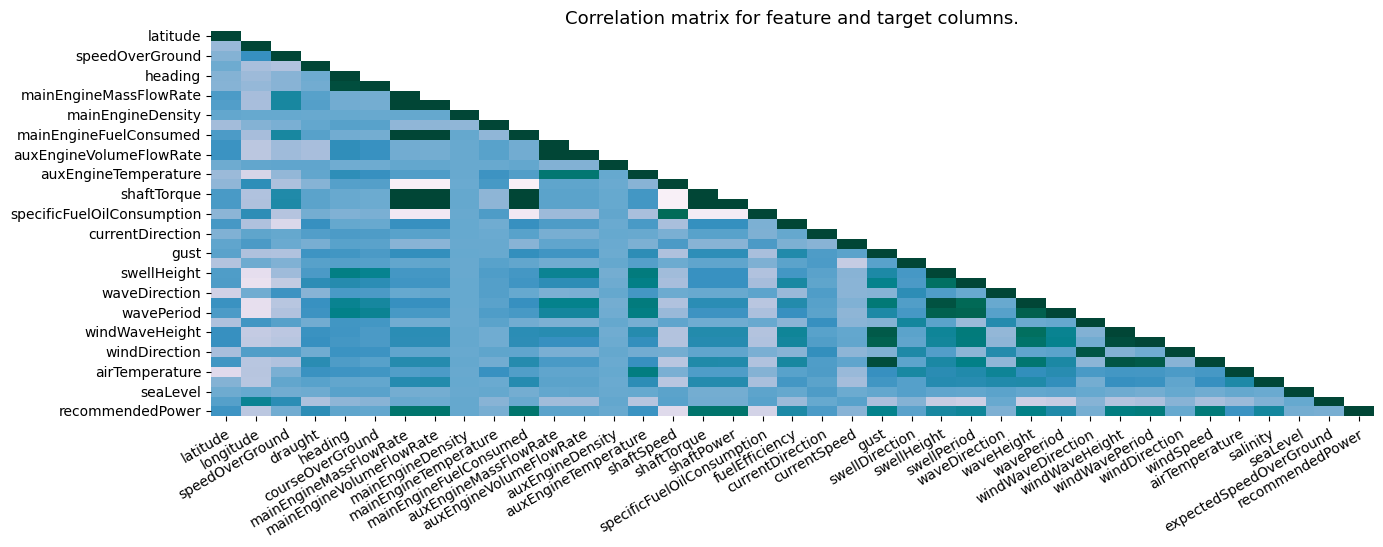

In [14]:
def compute_correlations_matrix(data=df_clean):
    """
    Compute and display a heatmap of the correlation matrix for numerical features.    
    :param dataset: pandas DataFrame containing the input data.
    :return: pandas DataFrame of the correlation matrix.
    """
    plt.figure(figsize=(15, 5))
    correlation_matrix = data.select_dtypes(include='number').corr()
    triangular_matrix = np.triu(correlation_matrix, k=1)

    sns.heatmap(
      data=correlation_matrix,
      center=0,
      cmap= 'PuBuGn',
      cbar=False,
      annot=False,
      mask=triangular_matrix
    )
    plt.xticks(rotation=30,ha='right', rotation_mode="anchor")
    plt.title("Correlation matrix for feature and target columns.", fontsize=13);
    return correlation_matrix


correlations = compute_correlations_matrix(df_clean)

In [15]:
def top_correlations(data:pd.DataFrame=df_clean, corr_threshold:float=0.95)->pd.Series:
    """
    Identify and return highly correlated feature pairs above a specified threshold.
    :param data: pandas DataFrame containing the input dataset. Defaults to df_clean.
    :param corr_threshold: Correlation threshold to filter feature pairs. Default is 0.95.
    :return: A pandas Series with multi-index (feature pairs) and correlation values.
    """
    corrs = data.select_dtypes(include='number').corr()
    corrs = corrs.unstack().sort_values(ascending=False)
    corrs = corrs[(corrs.abs() > corr_threshold) & 
                        (corrs.index.get_level_values(0) != corrs.index.get_level_values(1))]
    corrs = corrs.drop_duplicates()
    return corrs

sorted_corr = top_correlations()

print(f"Features with correlation exceeding 0.95:")
sorted_corr

Features with correlation exceeding 0.95:


mainEngineMassFlowRate    mainEngineFuelConsumed      1.000000
shaftTorque               shaftPower                  0.999939
auxEngineMassFlowRate     auxEngineVolumeFlowRate     0.999697
mainEngineMassFlowRate    mainEngineVolumeFlowRate    0.997789
mainEngineVolumeFlowRate  mainEngineFuelConsumed      0.997789
shaftPower                mainEngineMassFlowRate      0.992238
mainEngineFuelConsumed    shaftPower                  0.992238
shaftTorque               mainEngineMassFlowRate      0.992138
mainEngineFuelConsumed    shaftTorque                 0.992138
shaftPower                mainEngineVolumeFlowRate    0.991649
mainEngineVolumeFlowRate  shaftTorque                 0.991582
dtype: float64

### Conclusion: multicollinearity detected, conduct feature selection:
- #### 	Drop/Combine/Regularize if linear (including ridge or lasso) or even SVM regressions used
- #### feature still selection recommended for tree based or Gradient Boosting models
- #### Will drop drop potentially derived or redundant features:
    - #### `mainEngineFuelConsumed`: Possibly a computed value from mass flow
    - #### `shaftTorque`: Torque can be derived from power
    - #### 	`auxEngineMassFlowRate`: Volume flow might be calculated from mass flow
    - #### `mainEngineMassFlowRate` and `mainEngineVolumeFlowRate`: (potential) intermediate measurements used to compute power

In [16]:
def select_features(data:pd.DataFrame=df_clean, features_to_drop:list=None)->pd.DataFrame:
    """
    Remove specified features (columns) from the input DataFrame.
    :param data: pandas DataFrame to process. Defaults to df_clean.
    :param features_to_drop: List of column names to drop. If None, returns the original DataFrame copy.
    :return: A new pandas DataFrame with the specified features removed.
    """
    df_new = data.copy(deep=True)
    if features_to_drop:
        df_new.drop(columns=features_to_drop, inplace=True)
    return df_new

In [17]:
redundant_features=[
    "mainEngineFuelConsumed",
    "shaftTorque", 
    "auxEngineMassFlowRate", 
    "mainEngineVolumeFlowRate", 
    "mainEngineMassFlowRate",
    ]

df_feat_sel = select_features(data=df_clean, features_to_drop=redundant_features)
df_feat_sel.sample(1)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,mainEngineDensity,mainEngineTemperature,auxEngineVolumeFlowRate,auxEngineDensity,...,windWaveDirection,windWaveHeight,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,expectedSpeedOverGround,recommendedPower
290106,57.8829,-1.85048,11.0,6.0,143,142.4,866.574,18.7499,0.0,865.641,...,153.99,0.61,2.96,165.2,7.6,5.1,34.99,0.69,9.906507,922692.476562


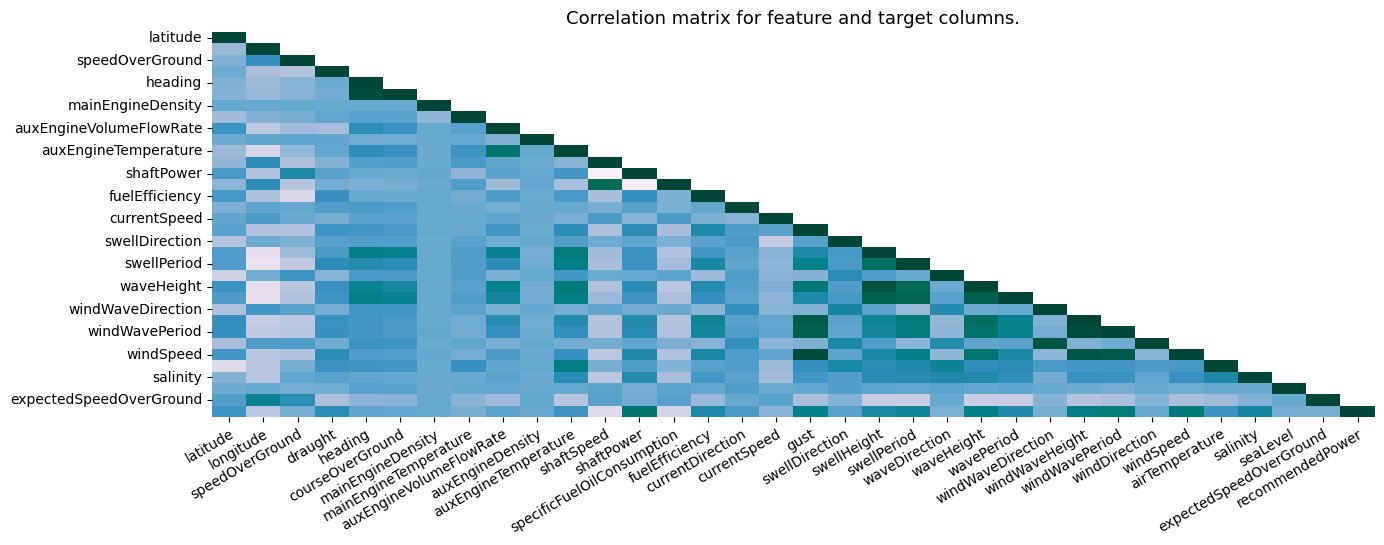

In [18]:
correlations = compute_correlations_matrix(df_feat_sel)

In [19]:
# Remove after testing
correlations_threshold = 0.90
sorted_corr_f = top_correlations(data=df_feat_sel, corr_threshold=correlations_threshold)

print(f"Features with correlation exceeding {correlations_threshold}:")
sorted_corr_f

Features with correlation exceeding 0.9:


windWavePeriod    windWaveHeight    0.942127
gust              windSpeed         0.941698
courseOverGround  heading           0.934886
waveHeight        swellHeight       0.917243
shaftPower        shaftSpeed       -0.907176
dtype: float64

In [20]:
df_feat_sel.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'mainEngineDensity', 'mainEngineTemperature',
       'auxEngineVolumeFlowRate', 'auxEngineDensity', 'auxEngineTemperature',
       'shaftSpeed', 'shaftPower', 'specificFuelOilConsumption', 'timestamp',
       'fuelEfficiency', 'currentDirection', 'currentSpeed', 'gust',
       'swellDirection', 'swellHeight', 'swellPeriod', 'waveDirection',
       'waveHeight', 'wavePeriod', 'windWaveDirection', 'windWaveHeight',
       'windWavePeriod', 'windDirection', 'windSpeed', 'airTemperature',
       'salinity', 'seaLevel', 'expectedSpeedOverGround', 'recommendedPower'],
      dtype='object')

## TODO: `speedOverGround` feature and target `expectedSpeedOverGround`???

### Feature Engineering

#### How aligned are the wind/current directions with the vessel heading? **(Must)**
These features can reveal resistance or assistance effects on vessel performance.


`def angular_difference(angle1, angle2):
    return np.abs(((angle1 - angle2 + 180) % 360) - 180)

data['wind_rel_heading'] = angular_difference(data['windDirection'], data['heading'])

data['current_rel_heading'] = angular_difference(data['currentDirection'], data['heading'])
`
### Cross and Head Components
Project environmental vectors relative to ship heading (e.g., crosswind/headwind) (**Optional**):

rel_angle = np.radians(angular_difference(data['windDirection'], data['heading']))

data['wind_head_component'] = data['windSpeed'] * np.cos(rel_angle)

data['wind_cross_component'] = data['windSpeed'] * np.sin(rel_angle)

Same for `currentSpeed`.

**Drop windSpeed features afterwards**

# TODO bellow: 
- add drop original columns option in the class bellow
- update docstrings
- consider incorporating other feature engineering classes, eg existing `eng_features` for directional sin/cos transformations

In [21]:
class AngularFeatureEngineer:
    def __init__(self,
                 data:pd.DataFrame=df_clean,
                 angular_features: list[str] = None,
                 env_force_features: list[tuple] = None,
                 base_angle_feat: str = "heading"):
        """
        Initialize the angular feature engineer.

        :param angular_features: List of angle-based feature column names (in degrees).
        :param env_force_features: List of environmental force features (e.g., windSpeed).
        :param base_angle_feat: Reference angle column (e.g., heading).
        """
        self.angular_features = angular_features or []
        self.env_force_features = env_force_features or []
        self.base_angle_feat = base_angle_feat
        self.data = data.copy(deep=True)

    @staticmethod
    def compute_relative_angle(angle1, angle2):
        """
        Compute the smallest signed angular difference between two angles.
        """
        return np.abs(((angle1 - angle2 + 180) % 360) - 180)


    def transform_angles(self, 
                        #  data:pd.DataFrame=df_clean  # remove after testing, redundant if data initialized with the class
                         ) -> pd.DataFrame:
        """
        Engineer angular interaction features:
        1) Compute relative angles between angular_features and base_angle_feat.

        :param data: Input DataFrame to transform.
        :return: DataFrame with added relative angle and decomposed force features.
        """
        df_angle =self.data
        # df_angle = data.copy(deep=True)
        if self.angular_features:
            for angle_feature in self.angular_features:
                angle_to_heading = self.compute_relative_angle(df_angle[angle_feature], df_angle[self.base_angle_feat])
                idx_angle = df_angle.columns.get_loc(angle_feature)

                df_angle.insert(loc=idx_angle + 1,
                              column=angle_feature + '_rel_head',
                              value=angle_to_heading)
        return df_angle

    def transform_forces(self,
                        #   data:pd.DataFrame=df_clean  # remove after testing, redundant if data initialized with the class
                          ) -> pd.DataFrame:
        """
        Engineer angular interaction features:
        1) Compute relative angles between angular_features and base_angle_feat.
        """
        df_force = self.data
        # df_force = data.copy(deep=True)
        if self.env_force_features:
            for force_feature in self.env_force_features:
                angle_col, force_col = force_feature
                rel_angle_rad = np.radians(self.compute_relative_angle(df_force[angle_col], df_force[self.base_angle_feat]))

                idx_force = df_force.columns.get_loc(force_col)
                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_head",
                                value=df_force[force_col] * np.cos(rel_angle_rad))

                # Insert cross-wind/current component
                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_cross",
                                value=df_force[force_col] * np.sin(rel_angle_rad))
        return df_force

    def transform(self, 
                #   data:pd.DataFrame=df_clean  # remove after testing, redundant if data initialized with the class
                  ) -> pd.DataFrame:
        """
        Apply angular and force feature transformations and return the result.

        :return: Transformed DataFrame with new features.
        """
        df_eng = self.transform_angles()
        df_eng = self.transform_forces()
        return df_eng

In [22]:
engineer = AngularFeatureEngineer(
    angular_features=['windDirection', 'currentDirection'],
    env_force_features=[("windDirection","windSpeed"), ("currentDirection", "currentSpeed")]
)
df_angle_and_force_feats = engineer.transform()
df_angle_and_force_feats.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'mainEngineMassFlowRate',
       'mainEngineVolumeFlowRate', 'mainEngineDensity',
       'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque', 'shaftPower',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentDirection_rel_head', 'currentSpeed',
       'currentSpeed_cross', 'currentSpeed_head', 'gust', 'swellDirection',
       'swellHeight', 'swellPeriod', 'waveDirection', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveHeight', 'windWavePeriod',
       'windDirection', 'windDirection_rel_head', 'windSpeed',
       'windSpeed_cross', 'windSpeed_head', 'airTemperature', 'salinity',
       'seaLevel', 'expectedSpeedOverGround', 'recommendedPower'],
      dtype='object')

In [23]:
df_angle_and_force_feats.sample(1)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,mainEngineTemperature,...,windDirection,windDirection_rel_head,windSpeed,windSpeed_cross,windSpeed_head,airTemperature,salinity,seaLevel,expectedSpeedOverGround,recommendedPower
316072,55.7558,15.5512,9.6,5.0,241,241.1,226.938,0.259947,872.896,14.9089,...,251.0,10.0,13.7,2.37898,13.491866,5.4,35.0,0.01,13.306237,1.102631e+06


#### Convert directions into sine and cosine components to preserve circularity (**Optional**)
`data['windDir_sin'] = np.sin(np.radians(data['windDirection']))

data['windDir_cos'] = np.cos(np.radians(data['windDirection']))

data['currentDir_sin'] = np.sin(np.radians(data['currentDirection']))

data['currentDir_cos'] = np.cos(np.radians(data['currentDirection']))­`

Apply to: `windDirection`, `currentDirection`, `waveDirection, swellDirection, windWaveDirection`

**Drop raw angle features afterwards**

In [24]:
def eng_direction_features(data:pd.DataFrame=df_clean, 
                 direction_features:list=None,
                 drop_original_features:bool=False)->pd.DataFrame:
    """
    Engineer directional features:
    1) Create a deep copy of the input dataset.
    2) Compute sine and cosine of specified directional columns (in degrees).
    3) Insert transformed features directly after the original column.
    4) Optionally drop original directional columns.
    :param data: Input DataFrame to transform.
    :param direction_features: List of column names to transform into sin/cos features.
    :param drop_original_features: If True, remove the original directional columns.
    :return: A DataFrame with directional features replaced or extended by their sine and cosine components.
    """
    df_eng = data.copy(deep=True)
    if direction_features:
        for feature in direction_features:
            sin =  np.sin(np.radians(df_eng[feature]))
            cos = np.cos(np.radians(df_eng[feature]))
            orig_feat_index = df_eng.columns.get_loc(feature)
            df_eng.insert(loc=orig_feat_index+1,column=feature+'_sin', value=sin)
            df_eng.insert(loc=orig_feat_index+1,column=feature+'_cos', value=cos)
        if drop_original_features:
            df_eng.drop(columns=direction_features, inplace=True)

    return df_eng

In [25]:
# remove after testing
df_circular_feats = eng_direction_features(direction_features=['windDirection', 'currentDirection'])
df_circular_feats.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'mainEngineMassFlowRate',
       'mainEngineVolumeFlowRate', 'mainEngineDensity',
       'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque', 'shaftPower',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentDirection_cos', 'currentDirection_sin',
       'currentSpeed', 'gust', 'swellDirection', 'swellHeight', 'swellPeriod',
       'waveDirection', 'waveHeight', 'wavePeriod', 'windWaveDirection',
       'windWaveHeight', 'windWavePeriod', 'windDirection',
       'windDirection_cos', 'windDirection_sin', 'windSpeed', 'airTemperature',
       'salinity', 'seaLevel', 'expectedSpeedOverGround', 'recommendedPower'],
      dtype='object')

In [26]:
df_circular_feats.sample(1)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,mainEngineTemperature,...,windWavePeriod,windDirection,windDirection_cos,windDirection_sin,windSpeed,airTemperature,salinity,seaLevel,expectedSpeedOverGround,recommendedPower
316501,55.2344,13.7884,10.4,5.0,270,271.8,181.18,0.207723,182.144,15.6166,...,3.88,240.0,-0.5,-0.866025,9.8,5.2,35.0,0.03,14.0,790396.345238


# TODO bellow:
- feature eng still not drafted
- consider merging with `AngularFeatureEngineer`  class

#### Power-to-Speed Efficiency (**Must**):
data['power_per_knot'] = data['shaftPower'] / (data['speedOverGround'] + 1e-3)

#### Engine Flow Ratios **(Optional)**:
data['auxEngineFuelMassFlow'] = data['auxEngineVolumeFlowRate'] * data['auxEngineDensity']

*Do the same for the main engine if volume flow is available.*

#### Normalized Shaft Power **(Optional)**:
data['shaftPower_per_rpm'] = data['shaftPower'] / (data['shaftSpeed'] + 1e-3)


| Feature Name                 | Description                                |
| ---------------------------- | ------------------------------------------ |
| `wind_rel_heading`           | Relative angle between wind and heading    |
| `current_rel_heading`        | Relative angle between current and heading |
| `wind_head_component`        | Wind component opposing or aiding ship     |
| `current_cross_component`    | Current’s sideward effect on ship          |
| `power_per_knot`             | Power required per unit speed              |
| `shaftPower_per_rpm`         | Power normalized by shaft speed            |
| `auxEngineFuelMassFlow`      | Estimated auxiliary fuel mass flow         |
| `windDir_sin`, `windDir_cos` | Trigonometric direction encoding           |
| `hour`, `dayofweek`          | Extracted from timestamp                   |


#### Position_cluster (via clustering latitude & longitude) To distinguish operating zones (e.g., open sea vs. harbor) **(Optional)**.

## Create 2 datasets:
### - w original and multicollinear features for trees/XGBoost
### - w/o or original features experiment w Lasso feature selection for linear models

In [27]:
df_clean.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'mainEngineMassFlowRate',
       'mainEngineVolumeFlowRate', 'mainEngineDensity',
       'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque', 'shaftPower',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentSpeed', 'gust', 'swellDirection',
       'swellHeight', 'swellPeriod', 'waveDirection', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveHeight', 'windWavePeriod',
       'windDirection', 'windSpeed', 'airTemperature', 'salinity', 'seaLevel',
       'expectedSpeedOverGround', 'recommendedPower'],
      dtype='object')

### Model Selection

### Training and Evaluation

## Final script
- create preprocess class
    - add preprocess_all function within the class
- consider feat eng class

In [28]:
# remove after testing:
def process_all(self, data: pd.DataFrame, 
                features_to_drop: list = None, 
                direction_features: list = None) -> pd.DataFrame:
    """
    Apply full preprocessing pipeline:
    1) Clean data.
    2) Drop specified features.
    3) Engineer directional features (sin/cos).
    
    :param data: Raw input DataFrame.
    :param features_to_drop: List of features to remove after cleaning.
    :param direction_features: List of directional columns to transform into sin/cos.
    :return: Fully preprocessed DataFrame.
    """
    df = self.clean_data(data)
    df = self.select_features(df, features_to_drop)
    df = self.eng_features(df, direction_features)
    return df
